# EGTA Framework Exploration

This notebook demonstrates how to use the Empirical Game-Theoretic Analysis (EGTA) framework to explore strategic interactions between agents deciding how to allocate their trading between traditional CDA markets and the MELO mechanism.

## Overview

1. Basic EGTA setup and running experiments
2. Analyzing equilibria and visualizing results
3. Parameter sweeps to understand how market conditions affect strategy selection
4. Advanced techniques for exploring larger strategy spaces

## 1. Setup and Imports

In [7]:
import os
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import Dict, List, Tuple, Any, Optional
from tqdm.notebook import tqdm
import fix_path
import widgetsnbextension

"""
Example code to fix import issues in the egta_exploration.ipynb notebook.

Copy the following code to the first cell of your notebook to fix
the 'No module named marketsim' error.
"""
import os
import sys
import json

# FIX PATH CONFIGURATION: Add the project root to Python path
notebook_dir = os.getcwd()  # Current working directory

# Check if we're in the examples directory
if notebook_dir.endswith('examples'):
    # We're in the examples directory, so parent is project root
    project_root = os.path.dirname(notebook_dir)
else:
    # Find the project root by looking for marketsim directory
    project_root = notebook_dir
    while not os.path.exists(os.path.join(project_root, 'marketsim')) and project_root != '/':
        project_root = os.path.dirname(project_root)
        
    if not os.path.exists(os.path.join(project_root, 'marketsim')):
        # Fallback - try parent of current directory
        project_root = os.path.dirname(notebook_dir)

# Add project root to Python path
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    print(f"Added {project_root} to Python path")
else:
    print(f"{project_root} already in Python path")

# Debug information
print(f"Current working directory: {notebook_dir}")
print(f"Project root directory: {project_root}")
print(f"sys.path: {sys.path[0]}")

# Try importing fix_path as a fallback
try:
    import fix_path
    fix_path.add_project_root_to_path()
except ImportError:
    print("Could not import fix_path module, using direct path configuration")

# Now test if marketsim can be imported
try:
    import marketsim
    print("Successfully imported marketsim module")
except ImportError as e:
    print(f"Error importing marketsim: {e}")
    print("Please make sure marketsim is installed or the path is correctly set")

# Rest of your imports should work now
from marketsim.egta.egta import EGTA
from marketsim.egta.simulators.melo_wrapper import MeloSimulator
from marketsim.egta.schedulers.dpr import DPRScheduler
from marketsim.egta.schedulers.random import RandomScheduler
from marketsim.egta.utils.visualization import (
    plot_equilibria, 
    plot_strategy_frequency, 
    plot_payoff_matrix,
    plot_regret_landscape,
    create_visualization_report
)
from marketsim.egta.core.game import Game
from marketsim.egta.solvers.equilibria import replicator_dynamics, quiesce, regret

# Set up plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

/Users/gabesmithline/Desktop/SRG/melo_project already in Python path
Current working directory: /Users/gabesmithline/Desktop/SRG/melo_project/examples
Project root directory: /Users/gabesmithline/Desktop/SRG/melo_project
sys.path: /Users/gabesmithline/Desktop/SRG/melo_project
/Users/gabesmithline/Desktop/SRG/melo_project already in Python path
Successfully imported marketsim module


In [8]:
!jupyter nbextension enable --py widgetsnbextension


usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: console contrib dejavu events execute kernel kernelspec
lab labextension labhub migrate nbconvert nbextensions_configurator notebook
run server troubleshoot trust

Jupyter command `jupyter-nbextension` not found.


## 2. Basic EGTA Experiment

Let's run a basic EGTA experiment to analyze how agents allocate trading between CDA and MELO markets.

In [9]:
# Create output directory
output_dir = 'results/egta_notebook'
os.makedirs(output_dir, exist_ok=True)

In [10]:
# Create MELO simulator with default parameters
simulator = MeloSimulator(
    num_strategic=10,  # Number of strategic MOBI agents
    sim_time=100,   # Simulation time horizon
    lam=0.1,         # Arrival rate
    mean=100,        # Mean fundamental value
    r=0.05,          # Mean reversion rate
    q_max=10,        # Maximum inventory
    holding_period=1, # MELO holding period
    reps=100          # Number of simulation repetitions per profile
)

# Get available strategies
strategies = simulator.get_strategies()
print(f"Available strategies: {strategies}")

# Print strategy parameters
print("\nStrategy parameters:")
for strategy in strategies:
    params = simulator.strategy_params[strategy]
    print(f"  {strategy}: CDA={params['cda_proportion']:.2f}, MELO={params['melo_proportion']:.2f}")

Available strategies: ['MELO_100_0', 'MELO_0_100']

Strategy parameters:
  MELO_100_0: CDA=1.00, MELO=0.00
  MELO_0_100: CDA=0.00, MELO=1.00


In [11]:
# Create DPR scheduler with reduction
scheduler = DPRScheduler(
    strategies=strategies,
    num_players=10,           # Full game has 10 players (N)
    reduction_size=4,         # Reduced game has 4 players (n)
    subgame_size=min(3, len(strategies)),
    batch_size=5,
    seed=42
)

# Print information about the scaling
print(f"DPR Scaling Info: {scheduler.get_scaling_info()}")
# Expected output: DPR Scaling Info: {'full_game_players'
# Create EGTA framework
egta = EGTA(
    simulator=simulator,
    scheduler=scheduler,
    device="cpu",     # Use CPU for computation
    output_dir=output_dir,
    max_profiles=1000,   # Maximum number of profiles to simulate
    seed=42           # Random seed for reproducibility
)

DPR Scaling Info: {'full_game_players': 10, 'reduced_game_players': 4, 'scaling_factor': 3.0, 'is_reduced': True}


In [12]:
# Run EGTA (this may take some time)
print("Starting EGTA experiment...")
print(f"Analyzing market allocation strategies: {strategies}")

game = egta.run(
    max_iterations=100, 
    profiles_per_iteration=100,  
    save_frequency=1,   
    verbose=True         
)

print("\nEGTA experiment completed!")

Starting EGTA experiment...
Analyzing market allocation strategies: ['MELO_100_0', 'MELO_0_100']

Iteration 1/100
Simulating 5 profiles...
Simulating profile 1/5: ['MELO_100_0', 'MELO_100_0', 'MELO_100_0', 'MELO_0_100']


100%|██████████| 100/100 [00:02<00:00, 40.65it/s]


Simulating profile 2/5: ['MELO_100_0', 'MELO_100_0', 'MELO_100_0', 'MELO_100_0']


100%|██████████| 100/100 [00:02<00:00, 38.35it/s]


Simulating profile 3/5: ['MELO_0_100', 'MELO_0_100', 'MELO_0_100', 'MELO_0_100']


  7%|▋         | 7/100 [00:00<00:01, 68.18it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price 394.50893832361726
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -1972.5446916180863
MELO Trade: Agent 16, Side -1, Quantity 5, Price 394.50893832361726
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 1972.5446916180863
MELO Trade: Agent 15, Side 1, Quantity 5, Price 144.89409924904226
Agent 15 MELO Profit before trade: 0
Agent 15 MELO Profit after trade: -724.4704962452113
MELO Trade: Agent 18, Side -1, Quantity 5, Price 144.89409924904226
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 724.4704962452113
MELO Trade: Agent 18, Side 1, Quantity 5, Price 29.999034005875252
Agent 18 MELO Profit before trade: 724.4704962452113
Agent 18 MELO Profit after trade: 574.475326215835
MELO Trade: Agent 15, Side -1, Quantity 5, Price 29.999034005875252
Agent 15 MELO Profit before trade: -724.4704962452113
Agent 15 MELO Profit after trade: -574.475326215835
MELO Trade: Agent 15, Sid

 23%|██▎       | 23/100 [00:00<00:01, 64.54it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price 136.3732724615298
Agent 17 MELO Profit before trade: 218.47337439094468
Agent 17 MELO Profit after trade: -463.3929879167044
MELO Trade: Agent 18, Side -1, Quantity 5, Price 136.3732724615298
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 681.8663623076491
MELO Trade: Agent 15, Side 1, Quantity 5, Price 143.95763725669016
Agent 15 MELO Profit before trade: 0
Agent 15 MELO Profit after trade: -719.7881862834508
MELO Trade: Agent 17, Side -1, Quantity 5, Price 143.95763725669016
Agent 17 MELO Profit before trade: -463.3929879167044
Agent 17 MELO Profit after trade: 256.39519836674646
MELO Trade: Agent 17, Side 1, Quantity 5, Price 142.8142318892809
Agent 17 MELO Profit before trade: 256.39519836674646
Agent 17 MELO Profit after trade: -457.67596107965807
MELO Trade: Agent 18, Side -1, Quantity 5, Price 142.8142318892809
Agent 18 MELO Profit before trade: 681.8663623076491
Agent 18 MELO Profit after trade: 1395.937521

 38%|███▊      | 38/100 [00:00<00:00, 67.88it/s]

MELO Trade: Agent 16, Side 1, Quantity 5, Price -224.13191013358855
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 1120.6595506679428
MELO Trade: Agent 15, Side -1, Quantity 5, Price -224.13191013358855
Agent 15 MELO Profit before trade: 0
Agent 15 MELO Profit after trade: -1120.6595506679428
MELO Trade: Agent 18, Side 1, Quantity 5, Price -197.70139847641002
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 988.5069923820502
MELO Trade: Agent 16, Side -1, Quantity 5, Price -197.70139847641002
Agent 16 MELO Profit before trade: 1120.6595506679428
Agent 16 MELO Profit after trade: 132.1525582858926
MELO Trade: Agent 17, Side 1, Quantity 5, Price 50.50336141230407
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -252.51680706152035
MELO Trade: Agent 16, Side -1, Quantity 5, Price 50.50336141230407
Agent 16 MELO Profit before trade: 132.1525582858926
Agent 16 MELO Profit after trade: 384.66936534741296
MELO Trade: Agent 15

 53%|█████▎    | 53/100 [00:00<00:00, 69.08it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price 179.90345546011514
Agent 17 MELO Profit before trade: 812.6754709034527
Agent 17 MELO Profit after trade: -86.84180639712292
MELO Trade: Agent 16, Side -1, Quantity 5, Price 179.90345546011514
Agent 16 MELO Profit before trade: -1159.3567718273694
Agent 16 MELO Profit after trade: -259.8394945267937
MELO Trade: Agent 15, Side 1, Quantity 5, Price 7.709496543449831
Agent 15 MELO Profit before trade: 0
Agent 15 MELO Profit after trade: -38.54748271724915
MELO Trade: Agent 17, Side -1, Quantity 5, Price 7.709496543449831
Agent 17 MELO Profit before trade: -86.84180639712292
Agent 17 MELO Profit after trade: -48.29432367987377
MELO Trade: Agent 17, Side 1, Quantity 5, Price 22.378128649764054
Agent 17 MELO Profit before trade: -48.29432367987377
Agent 17 MELO Profit after trade: -160.18496692869405
MELO Trade: Agent 16, Side -1, Quantity 5, Price 22.378128649764054
Agent 16 MELO Profit before trade: -259.8394945267937
Agent 16 MELO Profit aft

 68%|██████▊   | 68/100 [00:00<00:00, 69.79it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price 123.69926725903076
Agent 17 MELO Profit before trade: 1999.686151311231
Agent 17 MELO Profit after trade: 1381.1898150160773
MELO Trade: Agent 18, Side -1, Quantity 5, Price 123.69926725903076
Agent 18 MELO Profit before trade: -1271.2610674613802
Agent 18 MELO Profit after trade: -652.7647311662264
MELO Trade: Agent 17, Side 1, Quantity 5, Price 102.54119260034355
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -512.7059630017177
MELO Trade: Agent 16, Side -1, Quantity 5, Price 102.54119260034355
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 512.7059630017177
MELO Trade: Agent 18, Side 1, Quantity 5, Price 408.9695961360537
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -2044.8479806802686
MELO Trade: Agent 16, Side -1, Quantity 5, Price 408.9695961360537
Agent 16 MELO Profit before trade: 512.7059630017177
Agent 16 MELO Profit after trade: 2557.5539436819863
MELO Tr

 84%|████████▍ | 84/100 [00:01<00:00, 70.85it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price 295.22957448326133
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -1476.1478724163067
MELO Trade: Agent 16, Side -1, Quantity 5, Price 295.22957448326133
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 1476.1478724163067
MELO Trade: Agent 17, Side 1, Quantity 5, Price -134.0400097523337
Agent 17 MELO Profit before trade: -1476.1478724163067
Agent 17 MELO Profit after trade: -805.9478236546381
MELO Trade: Agent 18, Side -1, Quantity 5, Price -134.0400097523337
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -670.2000487616685
MELO Trade: Agent 15, Side 1, Quantity 5, Price -142.8975829529689
Agent 15 MELO Profit before trade: 0
Agent 15 MELO Profit after trade: 714.4879147648444
MELO Trade: Agent 18, Side -1, Quantity 5, Price -142.8975829529689
Agent 18 MELO Profit before trade: -670.2000487616685
Agent 18 MELO Profit after trade: -1384.687963526513
MELO Trade: Agent 18

 92%|█████████▏| 92/100 [00:01<00:00, 65.46it/s]

MELO Trade: Agent 16, Side 1, Quantity 5, Price 451.1867211475293
Agent 16 MELO Profit before trade: 1699.1735945826472
Agent 16 MELO Profit after trade: -556.7600111549991
MELO Trade: Agent 18, Side -1, Quantity 5, Price 451.1867211475293
Agent 18 MELO Profit before trade: -2875.0844071214665
Agent 18 MELO Profit after trade: -619.1508013838202
MELO Trade: Agent 16, Side 1, Quantity 5, Price -462.6855700854186
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 2313.427850427093
MELO Trade: Agent 17, Side -1, Quantity 5, Price -462.6855700854186
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -2313.427850427093
MELO Trade: Agent 16, Side 1, Quantity 5, Price -174.5787842339666
Agent 16 MELO Profit before trade: 2313.427850427093
Agent 16 MELO Profit after trade: 3186.321771596926
MELO Trade: Agent 17, Side -1, Quantity 5, Price -174.5787842339666
Agent 17 MELO Profit before trade: -2313.427850427093
Agent 17 MELO Profit after trade: -3186.3217

100%|██████████| 100/100 [00:01<00:00, 68.04it/s]


MELO Trade: Agent 15, Side 1, Quantity 5, Price 187.53345846119865
Agent 15 MELO Profit before trade: 0
Agent 15 MELO Profit after trade: -937.6672923059932
MELO Trade: Agent 18, Side -1, Quantity 5, Price 187.53345846119865
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 937.6672923059932
MELO Trade: Agent 17, Side 1, Quantity 5, Price 321.49619490630175
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -1607.4809745315088
MELO Trade: Agent 16, Side -1, Quantity 5, Price 321.49619490630175
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 1607.4809745315088
MELO Trade: Agent 16, Side 1, Quantity 5, Price 211.0228961251348
Agent 16 MELO Profit before trade: 1607.4809745315088
Agent 16 MELO Profit after trade: 552.3664939058349
MELO Trade: Agent 18, Side -1, Quantity 5, Price 211.0228961251348
Agent 18 MELO Profit before trade: 937.6672923059932
Agent 18 MELO Profit after trade: 1992.781772931667
MELO Trade: Agent 16, Side

  5%|▌         | 5/100 [00:00<00:02, 43.51it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([-1666.1951])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 8330.975341796875
MELO Trade: Agent 16, Side -1, Quantity 5, Price tensor([-1666.1951])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: -8330.975341796875
MELO Trade: Agent 16, Side 1, Quantity 5, Price tensor([-633.1957])
Agent 16 MELO Profit before trade: -8330.975341796875
Agent 16 MELO Profit after trade: -5164.9969482421875
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([-633.1957])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -3165.9783935546875
MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([-390.8005])
Agent 18 MELO Profit before trade: 8330.975341796875
Agent 18 MELO Profit after trade: 10284.977722167969
MELO Trade: Agent 16, Side -1, Quantity 5, Price tensor([-390.8005])
Agent 16 MELO Profit before trade: -5164.9969482421875
Agent 16 MELO Profit after trade: -7118.99932861

 15%|█▌        | 15/100 [00:00<00:01, 46.29it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([-117.5815])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 587.90771484375
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([-117.5815])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -587.90771484375
MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([625.7700])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -3128.85009765625
MELO Trade: Agent 16, Side -1, Quantity 5, Price tensor([625.7700])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 3128.85009765625
MELO Trade: Agent 16, Side 1, Quantity 5, Price 211.97534727736684
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: -1059.8767363868342
MELO Trade: Agent 17, Side -1, Quantity 5, Price 211.97534727736684
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 1059.8767363868342
MELO Trade: Agent 17, Side 1, Quantity 5, Price 514.96584068

 27%|██▋       | 27/100 [00:00<00:01, 49.65it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price 593.292118072529
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -2966.460590362645
MELO Trade: Agent 17, Side -1, Quantity 5, Price 593.292118072529
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 2966.460590362645
MELO Trade: Agent 18, Side 1, Quantity 5, Price 535.6110937668315
Agent 18 MELO Profit before trade: -2966.460590362645
Agent 18 MELO Profit after trade: -5644.5160591968015
MELO Trade: Agent 17, Side -1, Quantity 5, Price 535.6110937668315
Agent 17 MELO Profit before trade: 2966.460590362645
Agent 17 MELO Profit after trade: 5644.5160591968015
MELO Trade: Agent 16, Side 1, Quantity 5, Price 779.0960023986734
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: -3895.480011993367
MELO Trade: Agent 17, Side -1, Quantity 5, Price 779.0960023986734
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 3895.480011993367
MELO Trade: Agent 16, Side 1, Q

 37%|███▋      | 37/100 [00:00<00:01, 49.46it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price -485.12375138899006
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 2425.6187569449503
MELO Trade: Agent 16, Side -1, Quantity 5, Price -485.12375138899006
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: -2425.6187569449503
MELO Trade: Agent 17, Side 1, Quantity 5, Price 153.89437607848288
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -769.4718803924144
MELO Trade: Agent 18, Side -1, Quantity 5, Price 153.89437607848288
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 769.4718803924144
MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([93.2450])
Agent 17 MELO Profit before trade: -769.4718803924144
Agent 17 MELO Profit after trade: -1235.6970848601877
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([93.2450])
Agent 18 MELO Profit before trade: 769.4718803924144
Agent 18 MELO Profit after trade: 1235.6970848601877
MELO Trade: Agent 17,

 47%|████▋     | 47/100 [00:00<00:01, 49.23it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([-1113.2740])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 5566.3702392578125
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([-1113.2740])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -5566.3702392578125
MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([-486.5096])
Agent 17 MELO Profit before trade: -5566.3702392578125
Agent 17 MELO Profit after trade: -3133.822021484375
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([-486.5096])
Agent 18 MELO Profit before trade: 5566.3702392578125
Agent 18 MELO Profit after trade: 3133.822021484375
MELO Trade: Agent 16, Side 1, Quantity 5, Price tensor([1549.9344])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: -7749.6722412109375
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([1549.9344])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 7749.6722412109375
MELO Trade:

 59%|█████▉    | 59/100 [00:01<00:00, 49.71it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price 323.8438455521606
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -1619.2192277608028
MELO Trade: Agent 16, Side -1, Quantity 5, Price 323.8438455521606
Agent 16 MELO Profit before trade: 2208.4797464072453
Agent 16 MELO Profit after trade: 3827.698974168048
MELO Trade: Agent 17, Side 1, Quantity 5, Price 159.54420391944348
Agent 17 MELO Profit before trade: -2208.4797464072453
Agent 17 MELO Profit after trade: -3006.200766004463
MELO Trade: Agent 18, Side -1, Quantity 5, Price 159.54420391944348
Agent 18 MELO Profit before trade: -1619.2192277608028
Agent 18 MELO Profit after trade: -821.4982081635854
MELO Trade: Agent 16, Side 1, Quantity 5, Price -395.0876502867608
Agent 16 MELO Profit before trade: 3827.698974168048
Agent 16 MELO Profit after trade: 5803.137225601852
MELO Trade: Agent 18, Side -1, Quantity 5, Price -395.0876502867608
Agent 18 MELO Profit before trade: -821.4982081635854
Agent 18 MELO Profit afte

 71%|███████   | 71/100 [00:01<00:00, 50.57it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([1468.3378])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -7341.6888427734375
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([1468.3378])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 7341.6888427734375
MELO Trade: Agent 18, Side 1, Quantity 5, Price 404.2936718094407
Agent 18 MELO Profit before trade: -7341.6888427734375
Agent 18 MELO Profit after trade: -9363.15720182064
MELO Trade: Agent 16, Side -1, Quantity 5, Price 404.2936718094407
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 2021.4683590472034
MELO Trade: Agent 16, Side 1, Quantity 5, Price -577.396040770536
Agent 16 MELO Profit before trade: 2021.4683590472034
Agent 16 MELO Profit after trade: 4908.448562899884
MELO Trade: Agent 17, Side -1, Quantity 5, Price -577.396040770536
Agent 17 MELO Profit before trade: 7341.6888427734375
Agent 17 MELO Profit after trade: 4454.708638920757
MELO Tr

 77%|███████▋  | 77/100 [00:01<00:00, 50.04it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price 182.06794651465975
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -910.3397325732988
MELO Trade: Agent 18, Side -1, Quantity 5, Price 182.06794651465975
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 910.3397325732988
MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([-53.0009])
Agent 17 MELO Profit before trade: -910.3397325732988
Agent 17 MELO Profit after trade: -645.3354791858476
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([-53.0009])
Agent 18 MELO Profit before trade: 910.3397325732988
Agent 18 MELO Profit after trade: 645.3354791858476
MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([985.2107])
Agent 18 MELO Profit before trade: 645.3354791858476
Agent 18 MELO Profit after trade: -4280.717987611028
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([985.2107])
Agent 17 MELO Profit before trade: -645.3354791858476
Agent 17 MELO Profit after trade: 4280.71798

 89%|████████▉ | 89/100 [00:01<00:00, 50.53it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price -941.3889790986481
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 4706.94489549324
MELO Trade: Agent 16, Side -1, Quantity 5, Price -941.3889790986481
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: -4706.94489549324
MELO Trade: Agent 17, Side 1, Quantity 5, Price 281.28350589972274
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -1406.4175294986137
MELO Trade: Agent 18, Side -1, Quantity 5, Price 281.28350589972274
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 1406.4175294986137
MELO Trade: Agent 17, Side 1, Quantity 5, Price 456.2769471285809
Agent 17 MELO Profit before trade: -1406.4175294986137
Agent 17 MELO Profit after trade: -3687.8022651415185
MELO Trade: Agent 16, Side -1, Quantity 5, Price 456.2769471285809
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 2281.3847356429046
MELO Trade: Agent 18, Side 1, Quantity 5

100%|██████████| 100/100 [00:02<00:00, 49.49it/s]


MELO Trade: Agent 18, Side 1, Quantity 5, Price 224.53068375805037
Agent 18 MELO Profit before trade: -2114.213498354416
Agent 18 MELO Profit after trade: -3236.866917144668
MELO Trade: Agent 17, Side -1, Quantity 5, Price 224.53068375805037
Agent 17 MELO Profit before trade: 2114.213498354416
Agent 17 MELO Profit after trade: 3236.866917144668
MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([-128.9769])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 644.8845672607422
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([-128.9769])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -644.8845672607422
MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([434.7127])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -2173.5633850097656
MELO Trade: Agent 16, Side -1, Quantity 5, Price tensor([434.7127])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 2173.5633850097656
MELO Trade: Agent 16,

  0%|          | 0/100 [00:00<?, ?it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price -170.3555103030472
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 851.7775515152359
MELO Trade: Agent 18, Side -1, Quantity 5, Price -170.3555103030472
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -851.7775515152359
MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([1654.5870])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -8272.935180664062
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([1654.5870])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 8272.935180664062


 10%|█         | 10/100 [00:00<00:02, 43.28it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price -470.10687198413984
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 2350.534359920699
MELO Trade: Agent 18, Side -1, Quantity 5, Price -470.10687198413984
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -2350.534359920699
MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([1189.8973])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -5949.4866943359375
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([1189.8973])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 5949.4866943359375
MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([1099.2080])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -5496.0400390625
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([1099.2080])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 5496.0400390625
MELO Trade: Agent 18, Side 1, Quantity 5, Price 273.20

 20%|██        | 20/100 [00:00<00:01, 42.69it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([-568.4663])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 2842.33154296875
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([-568.4663])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -2842.33154296875
MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([-873.3911])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 4366.955261230469
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([-873.3911])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -4366.955261230469
MELO Trade: Agent 18, Side 1, Quantity 5, Price 166.06826386893712
Agent 18 MELO Profit before trade: -4366.955261230469
Agent 18 MELO Profit after trade: -5197.296580575155
MELO Trade: Agent 17, Side -1, Quantity 5, Price 166.06826386893712
Agent 17 MELO Profit before trade: 4366.955261230469
Agent 17 MELO Profit after trade: 5197.296580575155
MELO Trade: Agent 17, S

 25%|██▌       | 25/100 [00:00<00:01, 42.46it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([-657.6798])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 3288.3990478515625
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([-657.6798])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -3288.3990478515625
MELO Trade: Agent 18, Side 1, Quantity 5, Price -562.1693662850006
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 2810.846831425003
MELO Trade: Agent 17, Side -1, Quantity 5, Price -562.1693662850006
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -2810.846831425003
MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([-3084.5137])
Agent 18 MELO Profit before trade: 2810.846831425003
Agent 18 MELO Profit after trade: 18233.415190800002
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([-3084.5137])
Agent 17 MELO Profit before trade: -2810.846831425003
Agent 17 MELO Profit after trade: -18233.415190800002
MELO Trade: Age

 30%|███       | 30/100 [00:00<00:01, 42.40it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price 244.93612937153063
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -1224.680646857653
MELO Trade: Agent 17, Side -1, Quantity 5, Price 244.93612937153063
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 1224.680646857653
MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([-1217.4929])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 6087.464599609375
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([-1217.4929])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -6087.464599609375


 35%|███▌      | 35/100 [00:00<00:01, 34.63it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([-1193.4924])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 5967.462158203125
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([-1193.4924])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -5967.462158203125
MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([1225.1304])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -6125.65185546875
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([1225.1304])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 6125.65185546875
MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([48.2138])
Agent 18 MELO Profit before trade: -6125.65185546875
Agent 18 MELO Profit after trade: -6366.7206954956055
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([48.2138])
Agent 17 MELO Profit before trade: 6125.65185546875
Agent 17 MELO Profit after trade: 6366.7206954956055
MELO Trade: Agent 17, S

 45%|████▌     | 45/100 [00:01<00:01, 39.06it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price -57.424265635126915
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 287.1213281756346
MELO Trade: Agent 18, Side -1, Quantity 5, Price -57.424265635126915
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -287.1213281756346
MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([1805.6410])
Agent 18 MELO Profit before trade: -287.1213281756346
Agent 18 MELO Profit after trade: -9315.326284230323
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([1805.6410])
Agent 17 MELO Profit before trade: 287.1213281756346
Agent 17 MELO Profit after trade: 9315.326284230323
MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([-2734.2319])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 13671.15966796875
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([-2734.2319])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -13671.15966796875
MELO Trade: Agent

 55%|█████▌    | 55/100 [00:01<00:01, 41.19it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price -118.07922273127771
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 590.3961136563886
MELO Trade: Agent 17, Side -1, Quantity 5, Price -118.07922273127771
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -590.3961136563886
MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([429.7555])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -2148.777313232422
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([429.7555])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 2148.777313232422
MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([-376.9724])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 1884.862060546875
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([-376.9724])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -1884.862060546875
MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor

 65%|██████▌   | 65/100 [00:01<00:00, 43.26it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price 525.1570755801322
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -2625.785377900661
MELO Trade: Agent 18, Side -1, Quantity 5, Price 525.1570755801322
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 2625.785377900661
MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([1721.1671])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -8605.835571289062
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([1721.1671])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 8605.835571289062
MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([1457.7458])
Agent 17 MELO Profit before trade: 8605.835571289062
Agent 17 MELO Profit after trade: 1317.1063232421875
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([1457.7458])
Agent 18 MELO Profit before trade: -8605.835571289062
Agent 18 MELO Profit after trade: -1317.1063232421875
MELO Trade: Agent 17,

 75%|███████▌  | 75/100 [00:01<00:00, 42.31it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([610.0132])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -3050.06591796875
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([610.0132])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 3050.06591796875
MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([139.5724])
Agent 18 MELO Profit before trade: 3050.06591796875
Agent 18 MELO Profit after trade: 2352.2039794921875
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([139.5724])
Agent 17 MELO Profit before trade: -3050.06591796875
Agent 17 MELO Profit after trade: -2352.2039794921875
MELO Trade: Agent 17, Side 1, Quantity 5, Price -131.87166136576752
Agent 17 MELO Profit before trade: -2352.2039794921875
Agent 17 MELO Profit after trade: -1692.84567266335
MELO Trade: Agent 18, Side -1, Quantity 5, Price -131.87166136576752
Agent 18 MELO Profit before trade: 2352.2039794921875
Agent 18 MELO Profit after trade: 1692.8456

 85%|████████▌ | 85/100 [00:02<00:00, 40.03it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([55.0504])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -275.25177001953125
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([55.0504])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 275.25177001953125
MELO Trade: Agent 18, Side 1, Quantity 5, Price 1061.631006224269
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -5308.155031121345
MELO Trade: Agent 17, Side -1, Quantity 5, Price 1061.631006224269
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 5308.155031121345
MELO Trade: Agent 18, Side 1, Quantity 5, Price -79.62577094525915
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 398.12885472629574
MELO Trade: Agent 17, Side -1, Quantity 5, Price -79.62577094525915
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -398.12885472629574
MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([51

 90%|█████████ | 90/100 [00:02<00:00, 41.05it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([2444.8430])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -12224.215087890625
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([2444.8430])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 12224.215087890625
MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([-1827.0089])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 9135.044555664062
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([-1827.0089])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -9135.044555664062
MELO Trade: Agent 18, Side 1, Quantity 5, Price -205.8323438601862
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 1029.161719300931
MELO Trade: Agent 17, Side -1, Quantity 5, Price -205.8323438601862
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -1029.161719300931
MELO Trade: Agent 18, Side 1, Quantity 5, Price te

100%|██████████| 100/100 [00:02<00:00, 36.87it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([-1047.3667])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 5236.83349609375
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([-1047.3667])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -5236.83349609375
MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([-99.1658])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 495.82923889160156
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([-99.1658])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -495.82923889160156
MELO Trade: Agent 18, Side 1, Quantity 5, Price 838.6947233053397
Agent 18 MELO Profit before trade: -495.82923889160156
Agent 18 MELO Profit after trade: -4689.3028554183
MELO Trade: Agent 17, Side -1, Quantity 5, Price 838.6947233053397
Agent 17 MELO Profit before trade: 495.82923889160156
Agent 17 MELO Profit after trade: 4689.3028554183
MELO Trade: Agent 18, Sid

## 3. Analyzing Equilibria

Now let's analyze the equilibria found by the EGTA process.

In [22]:
# Analyze equilibria
analysis = egta.analyze_equilibria(verbose=True)

# Save analysis
with open(os.path.join(output_dir, 'analysis.json'), 'w') as f:
    json.dump(analysis, f, indent=2)


Equilibria Analysis
Number of equilibria: 1
Average regret: 0.000000
Average support size: 1.00
Support size range: 1 - 1

Top strategies:
  MELO_100_0: 1.0000
  MELO_0_100: 0.0000


Top strategies by frequency:
  MELO_100_0: 1.0000
  MELO_0_100: 0.0000


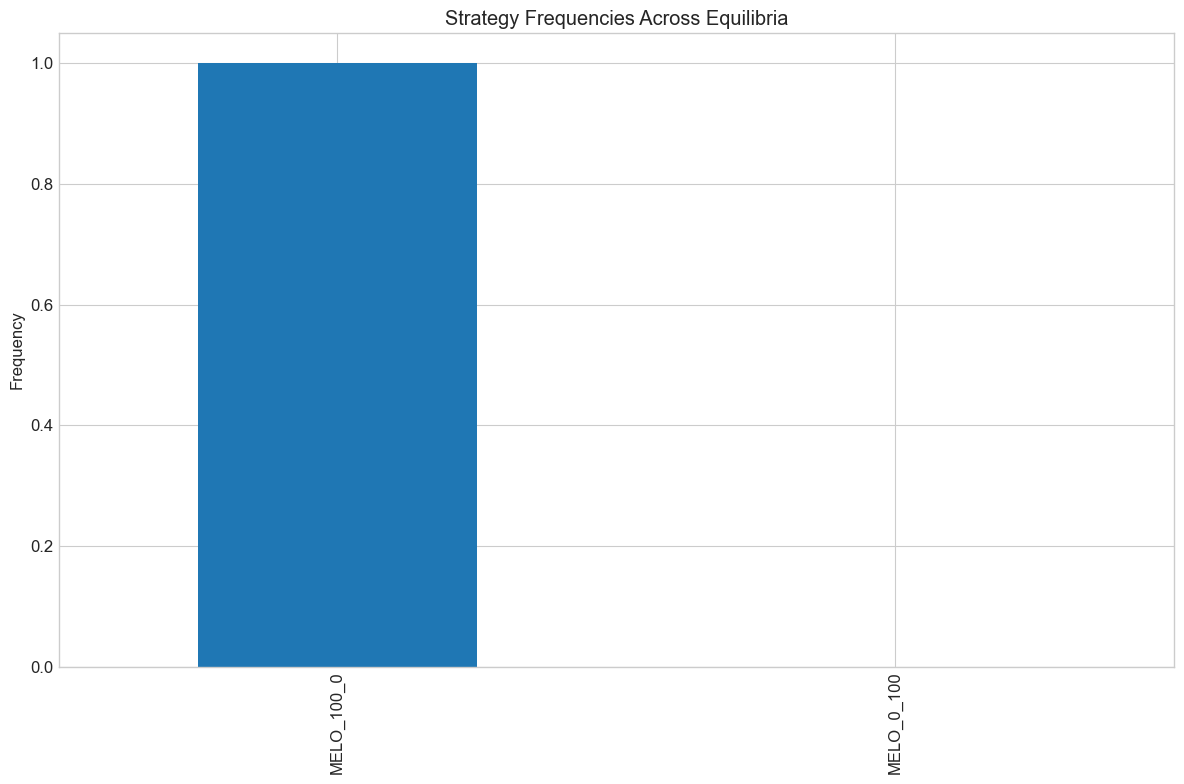

In [23]:
# Print top strategies
print("Top strategies by frequency:")
for strategy, freq in analysis['top_strategies']:
    print(f"  {strategy}: {freq:.4f}")

# Create a bar chart of strategy frequencies
strategy_freqs = pd.Series(analysis['strategy_frequencies'])
strategy_freqs.sort_values(ascending=False).plot(kind='bar')
plt.title('Strategy Frequencies Across Equilibria')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()  

## 4. Visualizing Results

## TODO FIX THIS

In [15]:
# Plot the equilibria as a heatmap
'''
plot_equilibria(
    game=game,
    equilibria=egta.equilibria,
    output_file=os.path.join(output_dir, 'equilibria.png'),
    show=True
)
'''

"\nplot_equilibria(\n    game=game,\n    equilibria=egta.equilibria,\n    output_file=os.path.join(output_dir, 'equilibria.png'),\n    show=True\n)\n"

In [16]:
# Plot strategy frequency
'''
plot_strategy_frequency(
    equilibria=egta.equilibria,
    strategy_names=game.strategy_names,
    output_file=os.path.join(output_dir, 'strategy_frequency.png'),
    show=True
)
'''

"\nplot_strategy_frequency(\n    equilibria=egta.equilibria,\n    strategy_names=game.strategy_names,\n    output_file=os.path.join(output_dir, 'strategy_frequency.png'),\n    show=True\n)\n"

In [17]:
# Plot payoff matrix
''''
plot_payoff_matrix(
    game=game,
    output_file=os.path.join(output_dir, 'payoff_matrix.png'),
    show=True
)
'''

"'\nplot_payoff_matrix(\n    game=game,\n    output_file=os.path.join(output_dir, 'payoff_matrix.png'),\n    show=True\n)\n"

In [18]:
# Plot regret landscapes for pairs of strategies
# This helps visualize where the equilibria are located
''''
if len(game.strategy_names) <= 5:  # Only if we have a manageable number of strategies
    for i in range(len(game.strategy_names)):
        for j in range(i+1, len(game.strategy_names)):
            plot_regret_landscape(
                game=game,
                strategies=[game.strategy_names[i], game.strategy_names[j]],
                resolution=50,  # Reduced resolution for speed
                output_file=os.path.join(output_dir, f'regret_landscape_{i}_{j}.png'),
                show=True
            )
'''

"'\nif len(game.strategy_names) <= 5:  # Only if we have a manageable number of strategies\n    for i in range(len(game.strategy_names)):\n        for j in range(i+1, len(game.strategy_names)):\n            plot_regret_landscape(\n                game=game,\n                strategies=[game.strategy_names[i], game.strategy_names[j]],\n                resolution=50,  # Reduced resolution for speed\n                output_file=os.path.join(output_dir, f'regret_landscape_{i}_{j}.png'),\n                show=True\n            )\n"

In [19]:
# Create a comprehensive visualization report
'''
vis_dir = os.path.join(output_dir, 'visualizations')
report_path = create_visualization_report(
    game=game,
    equilibria=egta.equilibria,
    output_dir=vis_dir
)

print(f"Visualization report saved to {report_path}")
print("Open this HTML file in a browser to view the visualization report")
'''

'\nvis_dir = os.path.join(output_dir, \'visualizations\')\nreport_path = create_visualization_report(\n    game=game,\n    equilibria=egta.equilibria,\n    output_dir=vis_dir\n)\n\nprint(f"Visualization report saved to {report_path}")\nprint("Open this HTML file in a browser to view the visualization report")\n'

## 5. Parameter Sweeps

Now let's explore how different market conditions affect the equilibrium strategies by running parameter sweeps.

In [20]:
def run_experiment(holding_period, lam):
    """Run an EGTA experiment with specific parameters."""
    # Create experiment directory
    exp_dir = f"{output_dir}/sweep_h{holding_period}_lam{lam}"
    os.makedirs(exp_dir, exist_ok=True)
    
    # Create simulator with specific parameters
    simulator = MeloSimulator(
        num_players=10,
        sim_time=1000,
        lam=lam,             # Vary arrival rate
        mean=100,
        r=0.05,
        q_max=10,
        holding_period=holding_period,  # Vary holding period
        reps=2  # Use fewer repetitions for speed
    )
    
    # Create scheduler
    scheduler = DPRScheduler(
        strategies=simulator.get_strategies(),
        num_players=simulator.get_num_players(),
        subgame_size=min(4, len(simulator.get_strategies())),
        batch_size=3,
        seed=42
    )
    
    # Create EGTA framework
    egta = EGTA(
        simulator=simulator,
        scheduler=scheduler,
        device="cpu",
        output_dir=exp_dir,
        max_profiles=30,
        seed=42
    )
    
    # Run with fewer iterations for the parameter sweep
    game = egta.run(
        max_iterations=3,
        profiles_per_iteration=3,
        save_frequency=1,
        verbose=False  # Less verbose for parameter sweep
    )
    
    # Analyze equilibria
    analysis = egta.analyze_equilibria(verbose=False)
    
    # Save analysis
    with open(os.path.join(exp_dir, 'analysis.json'), 'w') as f:
        json.dump(analysis, f, indent=2)
    
    return {
        'holding_period': holding_period,
        'lam': lam,
        'equilibria': [(mix.tolist(), float(reg)) for mix, reg in egta.equilibria],
        'strategy_frequencies': analysis['strategy_frequencies'],
        'top_strategies': analysis['top_strategies']
    }

In [21]:
# Define parameter grid
holding_periods = [1, 5, 10]  # Different MELO holding periods
lambdas = [0.05, 0.1, 0.2]    # Different arrival rates

# Run experiments
results = []
for h in holding_periods:
    print(f"Processing holding period: {h}")
    for lam in lambdas:
        print(f"\nRunning experiment with holding_period={h}, lambda={lam}")
        result = run_experiment(h, lam)
        results.append(result)
        print(f"Completed experiment. Found {len(result['equilibria'])} equilibria.")

# Save all results
with open(os.path.join(output_dir, 'parameter_sweep_results.json'), 'w') as f:
    json.dump(results, f, indent=2)

Processing holding period: 1

Running experiment with holding_period=1, lambda=0.05


TypeError: MeloSimulator.__init__() got an unexpected keyword argument 'num_players'

In [ ]:
sweep_df = pd.DataFrame(results)

def get_top_strategy(row):
    if row['top_strategies']:
        return row['top_strategies'][0][0] 
    return None

sweep_df['top_strategy'] = sweep_df.apply(get_top_strategy, axis=1)

pivot = pd.pivot_table(
    sweep_df, 
    values='top_strategy', 
    index='holding_period', 
    columns='lam',
    aggfunc=lambda x: x
)

print("Top strategy by holding period and arrival rate:")
display(pivot)

plt.figure(figsize=(12, 8))
strategies = simulator.get_strategies()

fig, axes = plt.subplots(len(holding_periods), len(lambdas), figsize=(15, 10))
fig.suptitle('Strategy Frequencies by Market Conditions', fontsize=16)

for i, h in enumerate(holding_periods):
    axes[i, 0].set_ylabel(f'Holding Period = {h}')
    
for j, lam in enumerate(lambdas):
    axes[0, j].set_title(f'λ = {lam}')

for i, h in enumerate(holding_periods):
    for j, lam in enumerate(lambdas):
        result = next((r for r in results if r['holding_period'] == h and r['lam'] == lam), None)
        if result:
            freqs = pd.Series(result['strategy_frequencies'])
            freqs.plot(kind='bar', ax=axes[i, j])
            axes[i, j].set_xticklabels(axes[i, j].get_xticklabels(), rotation=90)
            axes[i, j].set_ylim(0, 1)
            
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(os.path.join(output_dir, 'parameter_sweep_heatmap.png'), dpi=300, bbox_inches='tight')
plt.show()

## 6. Advanced EGTA - Custom Strategy Space

Let's explore how to define and analyze a custom strategy space, with more fine-grained allocation proportions.

In [17]:
class CustomMeloSimulator(MeloSimulator):
    """Extended MeloSimulator with custom strategy space."""
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        # more fine-grained strategy space
        self.strategies = [
            "MELO_100_0",   # 100% CDA, 0% MELO
            "MELO_90_10",   # 90% CDA, 10% MELO
            "MELO_80_20",   # 80% CDA, 20% MELO
            "MELO_70_30",   # 70% CDA, 30% MELO
            "MELO_60_40",   # 60% CDA, 40% MELO
            "MELO_50_50",   # 50% CDA, 50% MELO
            "MELO_40_60",   # 40% CDA, 60% MELO
            "MELO_30_70",   # 30% CDA, 70% MELO
            "MELO_20_80",   # 20% CDA, 80% MELO
            "MELO_10_90",   # 10% CDA, 90% MELO
            "MELO_0_100",   # 0% CDA, 100% MELO
        ]
        
        # strategy parameters
        self.strategy_params = {}
        for strategy in self.strategies:
            # Parse the strategy name to get proportions
            parts = strategy.split('_')
            cda_prop = int(parts[1]) / 100
            melo_prop = int(parts[2]) / 100
            self.strategy_params[strategy] = {
                "cda_proportion": cda_prop,
                "melo_proportion": melo_prop
            }

In [ ]:
custom_output_dir = f"{output_dir}/custom_strategy_space"
os.makedirs(custom_output_dir, exist_ok=True)

custom_simulator = CustomMeloSimulator(
    num_players=10,
    sim_time=1000,
    lam=0.1,
    holding_period=5,
    reps=2  # Use fewer repetitions for speed
)

#Print available strategies
strategies = custom_simulator.get_strategies()
print(f"Available strategies: {strategies}")

#Print strategy parameters
print("\nStrategy parameters:")
for strategy in strategies:
    params = custom_simulator.strategy_params[strategy]
    print(f"  {strategy}: CDA={params['cda_proportion']:.2f}, MELO={params['melo_proportion']:.2f}")

In [19]:
custom_scheduler = RandomScheduler(
    strategies=strategies,
    num_players=custom_simulator.get_num_players(),
    batch_size=5,
    seed=42
)

custom_egta = EGTA(
    simulator=custom_simulator,
    scheduler=custom_scheduler,
    device="cpu",
    output_dir=custom_output_dir,
    max_profiles=40,
    seed=42
)

In [ ]:
print("Starting EGTA experiment with custom strategy space...")
print(f"Analyzing {len(strategies)} different allocation strategies")

custom_game = custom_egta.run(
    max_iterations=4,
    profiles_per_iteration=5,
    save_frequency=1,
    verbose=True
)

print("\nEGTA experiment completed!")

In [ ]:
custom_analysis = custom_egta.analyze_equilibria(verbose=True)

with open(os.path.join(custom_output_dir, 'analysis.json'), 'w') as f:
    json.dump(custom_analysis, f, indent=2)

In [ ]:
custom_vis_dir = os.path.join(custom_output_dir, 'visualizations')
custom_report_path = create_visualization_report(
    game=custom_game,
    equilibria=custom_egta.equilibria,
    output_dir=custom_vis_dir
)

print(f"Visualization report saved to {custom_report_path}")

## 7. Analysis of Optimal Allocation Curve

## TODO, WE MIGHT want some analysis of metrics, stats. 


In [23]:
def run_holding_period_sweep(holding_periods):
    """Run experiments across different holding periods."""
    sweep_results = []
    
    for holding_period in tqdm(holding_periods):
        # Create experiment directory
        exp_dir = f"{output_dir}/holding_sweep_{holding_period}"
        os.makedirs(exp_dir, exist_ok=True)
        
        # Create simulator with specific holding period
        sim = CustomMeloSimulator(
            num_players=10,
            sim_time=1000,
            lam=0.1,
            holding_period=holding_period,
            reps=2
        )
        
        # Create scheduler
        sched = DPRScheduler(
            strategies=sim.get_strategies(),
            num_players=sim.get_num_players(),
            subgame_size=5,  # Use a larger subgame size for more exploration
            batch_size=4,
            seed=42
        )
        
        # Create EGTA framework
        egta_instance = EGTA(
            simulator=sim,
            scheduler=sched,
            device="cpu",
            output_dir=exp_dir,
            max_profiles=30,
            seed=42
        )
        
        # Run EGTA
        game = egta_instance.run(
            max_iterations=3,
            profiles_per_iteration=4,
            save_frequency=1,
            verbose=False
        )
        
        # Analyze equilibria
        analysis = egta_instance.analyze_equilibria(verbose=False)
        
        # Extract CDA proportions from top strategies
        cda_proportions = []
        for eq_mix, _ in egta_instance.equilibria:
            eq_strat_freqs = dict(zip(game.strategy_names, eq_mix.tolist()))
            weighted_cda_prop = 0
            for strat, freq in eq_strat_freqs.items():
                if freq > 0.01:  # Only count strategies with significant probability
                    cda_prop = sim.strategy_params[strat]['cda_proportion']
                    weighted_cda_prop += cda_prop * freq
            cda_proportions.append(weighted_cda_prop)
        
        # Calculate average CDA proportion
        avg_cda_prop = np.mean(cda_proportions) if cda_proportions else None
        
        # Save results
        result = {
            'holding_period': holding_period,
            'avg_cda_proportion': avg_cda_prop,
            'cda_proportions': cda_proportions,
            'num_equilibria': len(egta_instance.equilibria),
            'top_strategies': analysis['top_strategies']
        }
        sweep_results.append(result)
        
    return sweep_results

In [ ]:
# Run a sweep across different holding periods
holding_periods = [1, 2, 3, 5, 7, 10, 15, 20]
holding_sweep_results = run_holding_period_sweep(holding_periods)

# Save results
with open(os.path.join(output_dir, 'holding_period_sweep_results.json'), 'w') as f:
    json.dump(holding_sweep_results, f, indent=2)

In [ ]:
# Create a dataframe from results
holding_df = pd.DataFrame(holding_sweep_results)

# Plot the relationship between holding period and CDA proportion
plt.figure(figsize=(10, 6))
plt.plot(holding_df['holding_period'], holding_df['avg_cda_proportion'], 'o-', linewidth=2, markersize=8)
plt.xlabel('MELO Holding Period')
plt.ylabel('Average CDA Proportion in Equilibrium')
plt.title('Optimal CDA Allocation vs. MELO Holding Period')
plt.grid(True)
plt.ylim(0, 1)
plt.savefig(os.path.join(output_dir, 'optimal_allocation_curve.png'), dpi=300, bbox_inches='tight')
plt.show()

# Display the data
display(holding_df[['holding_period', 'avg_cda_proportion', 'num_equilibria']])